# Model Testing Notebook: Loading Datasets & Pre-Trained Model

**Objective:**  
Load the pre-generated datasets and the pre-trained NumerosityCNN model, evaluate its performance on the test set, and visualize the results.

- Set reproducibility seed and import libraries.
- Load the saved datasets.
- Load the pre-trained model.
- Evaluate the model on the test set (loss, accuracy, confusion matrix, and classification report).
- Visualize sample predictions.

**Note:**  
Make sure that the files **`train_dataset.pt`,** **`val_dataset.pt`**, **`test_dataset.pt`** and **`final_numerosity_model.pt`** are in your working directory.



# Environment Setup and Seed Setting

In [1]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("Random seed set to 42 for reproducibility.")

Random seed set to 42 for reproducibility.


In [2]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Using device: NVIDIA L4


# Load Saved Datasets

In [4]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, random_split
from PIL import Image
from pathlib import Path

IMG_SIZE = 128
BASE_PATH = Path("pixel_ratio_dataset")
CATEGORIES = ['few', 'medium', 'many']
PATTERNS = ['vertical', 'horizontal', 'checkerbox', 'random']
LABEL_MAP = {'few': 0, 'medium': 1, 'many': 2}

class PixelRatioDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = Path(root_dir)
        self.image_paths = []
        self.labels = []
        for pattern in PATTERNS:
            for category in CATEGORIES:
                folder = self.root_dir / pattern / category
                paths = list(folder.glob("*.png"))
                self.image_paths.extend(paths)
                self.labels.extend([LABEL_MAP[category]] * len(paths))
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path)
        return self.transform(image), label

In [5]:
import warnings
warnings.filterwarnings("ignore", message="You are using `torch.load` with `weights_only=False`")

from torch.utils.data.dataset import Subset
import torch.serialization

torch.serialization.add_safe_globals([Subset])

# Load the saved datasets (train, validation, test)
train_dataset = torch.load("train_dataset.pt", weights_only=False)
val_dataset = torch.load("val_dataset.pt", weights_only=False)
test_dataset = torch.load("test_dataset.pt", weights_only=False)

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

# Create DataLoaders
batch_size = 32  # default value; can be tuned later
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train Dataset Size: 840
Validation Dataset Size: 180
Test Dataset Size: 180


# Define the Model Architecture

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return self.relu(out)

class NumerosityCNN(nn.Module):
    def __init__(self):
        super(NumerosityCNN, self).__init__()
        self.layer1 = nn.Sequential(
            ResidualBlock(1, 32),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(32, 64),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(64, 128),
            nn.MaxPool2d(2)
        )
        # Input size 128x128 becomes 16x16 after 3 rounds of 2x2 pooling.
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(128, 3)  # Three classes: Few, Medium, Many

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)  # Flatten
        out = torch.relu(self.fc1(out))
        out = self.dropout(out)
        return self.fc2(out)

# Load the Pre-Trained Model

### Load the pre-trained model from the saved checkpoint "final_numerosity_model.pt".

In [7]:
model = NumerosityCNN().to(device)
model.load_state_dict(torch.load("final_numerosity_model.pt", map_location=device))
model.eval()
print("Pre-trained model loaded successfully.")

Pre-trained model loaded successfully.


# Evaluate the Model on the Test Set

### Compute test loss, test accuracy and generate confusion matrix and classification report.

In [8]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    avg_loss = running_loss / len(dataloader)
    accuracy = np.mean(np.array(all_labels) == np.array(all_preds))
    return avg_loss, accuracy, all_labels, all_preds

criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy, test_labels, test_preds = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")

Test Loss: 41.1992, Test Accuracy: 53.33%


# Confusion Matrix

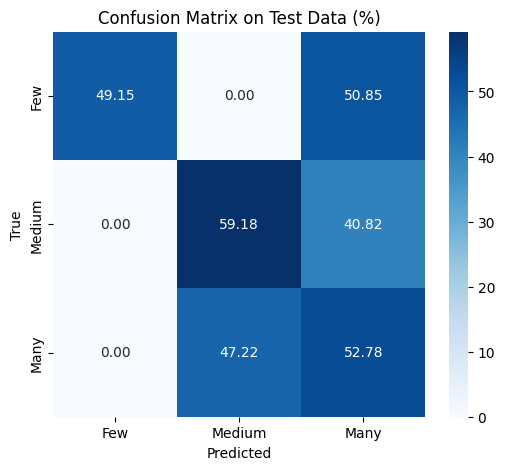

Classification Report:
              precision    recall  f1-score   support

         Few       1.00      0.49      0.66        59
      Medium       0.46      0.59      0.52        49
        Many       0.43      0.53      0.47        72

    accuracy                           0.53       180
   macro avg       0.63      0.54      0.55       180
weighted avg       0.63      0.53      0.55       180



In [9]:
cm = confusion_matrix(test_labels, test_preds)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentages

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=["Few", "Medium", "Many"],
            yticklabels=["Few", "Medium", "Many"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Test Data (%)")
plt.show()

print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=["Few", "Medium", "Many"]))

# Visualize Test Images with Predictions

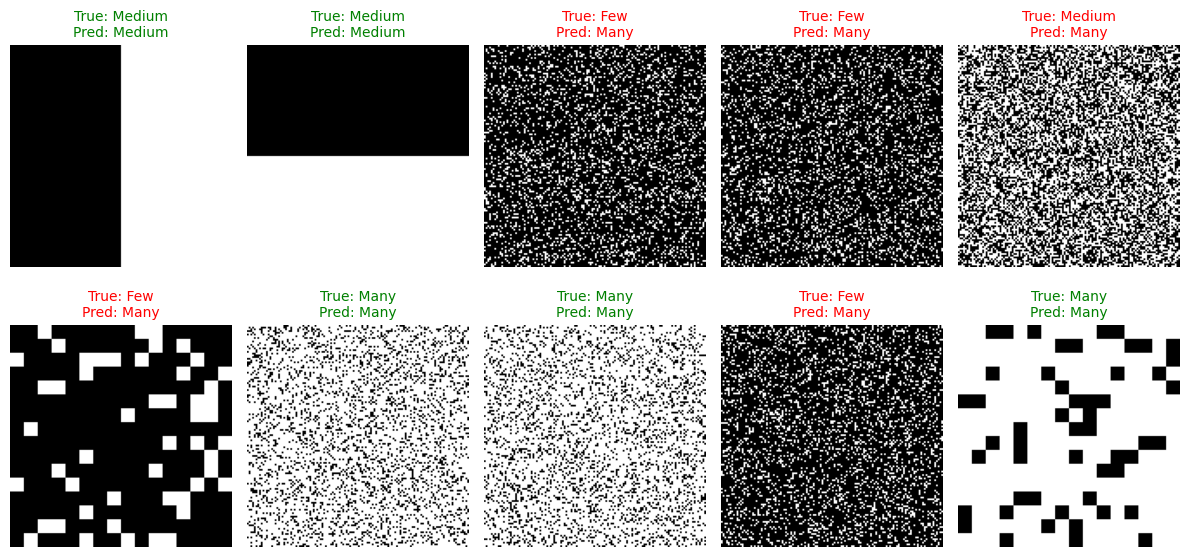

In [10]:
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Get model predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Map numeric labels to class names
label_names = {0: "Few", 1: "Medium", 2: "Many"}

# Plot images with predictions
plt.figure(figsize=(12, 6))
for i in range(10):  # Show 10 sample test images
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].cpu().squeeze(), cmap="gray")
    true_label = label_names[labels[i].item()]
    pred_label = label_names[predicted[i].item()]
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10, color="green" if true_label == pred_label else "red")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Save Experiment Results

In [11]:
results_dict = {
    "test_loss": [test_loss,],
    "test_accuracy": [test_accuracy]
}
pd.DataFrame(results_dict).to_csv("test_results_run.csv", index=False)
print("Test results saved as 'test_results_run.csv'.")

Test results saved as 'test_results_run.csv'.
